In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
import math
import os
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
from datetime import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.tsa.stattools as ts

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [8]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
df_berk = pd.read_csv(f"{homedir}/data/us/aggregate_berkeley.csv")
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))

In [9]:
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))

In [10]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)', 'Employed_2018', 'Unemployment_rate_2018'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)','fips']

In [11]:
# gets list of all fips numbers
def get_fips():
    Y = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
    return set(Y.countyFIPS.values)

def get_date(datestr, formatstr='%Y-%m-%d'):
    return datetime.strptime(datestr, formatstr)

In [12]:
class CumDeathCounter():
    def __init__(self):
        self.cum_deaths = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
        self.cum_deaths = self.cum_deaths.iloc[1:]
        fips_list = self.cum_deaths.countyFIPS.values
        
        self.cache = {}
        for fips in fips_list:
            self.cache[fips] = self.get_cum_deaths(fips)
    def get_cum_deaths(self, fips, clip_zeros=False):
        idx = self.cum_deaths.index[self.cum_deaths['countyFIPS'] == fips].values[0]
        county_deaths = self.cum_deaths.loc[self.cum_deaths['countyFIPS'] == fips]
        dates = pd.to_datetime(county_deaths.columns[4:].values).map(lambda dt : str(dt))
        X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
        y = []
        for i in range(4, len(county_deaths.columns)):
            y.append(county_deaths.loc[idx,county_deaths.columns[i]])
        if not clip_zeros:
            return X, y
        for i in range(len(y)):
            if y[i] != 0:
                return X[i:], y[i:]
    def getY(self, fips):
        return self.cache[fips]
class CumCaseCounter():
    def __init__(self):
        self.cum_cases = pd.read_csv(f"{homedir}/data/us/covid/confirmed_cases.csv")
        self.cum_cases = self.cum_cases.iloc[1:]
        self.cum_cases = self.cum_cases.iloc[:, :-1]
        
        fips_list = self.cum_cases.countyFIPS.values
        
        self.cache = {}
        for fips in fips_list:
            self.cache[fips] = self.get_cum_cases(fips)
        
    def get_cum_cases(self, fips,clip_zeros=False):
        idx = self.cum_cases.index[self.cum_cases['countyFIPS'] == fips].values[0]
        county_cases = self.cum_cases.loc[self.cum_cases['countyFIPS'] == fips]
        dates = pd.to_datetime(county_cases.columns[4:].values).map(lambda dt : str(dt))
        X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
        y = []
        for i in range(4, len(county_cases.columns)):
            y.append(county_cases.loc[idx,county_cases.columns[i]])
        if not clip_zeros:
            return X, y
        for i in range(len(y)):
            if y[i] != 0:
                return X[i:], y[i:]
    def getY(self, fips):
        return self.cache[fips]

In [13]:
cum_death_counter = CumDeathCounter()
cum_case_counter = CumCaseCounter()

In [14]:
NYT_counties_daily = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
# Gets the number of deaths per day of a given county along with the time, counted in days
# since Jan 1st
class DeltaDeathsCounter:
    def __init__(self, CumDeathsCounter):
        self.CumDeathsCounter = CumDeathsCounter
    def getY(self, fips):
        (X, y_cum) = self.CumDeathsCounter.getY(fips)
        y_delta = [0]
        for i in range(1, len(y_cum)):
            y_delta.append(y_cum[i] - y_cum[i-1])
        return X, y_delta

class DeltaCaseCounter:
    def __init__(self, CumCaseCounter):
        self.CumCaseCounter = CumCaseCounter
    def getY(self, fips):
        (X, y_cum) = self.CumCaseCounter.getY(fips)
        y_delta = [0]
        for i in range(1, len(y_cum)):
            y_delta.append(y_cum[i] - y_cum[i-1])
        return X, y_delta
def get_delta_cases(fips, clip_zeros=False):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date(start_date)).days)
    X, y = (Y_county.time.values, Y_county.cases.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]
class DeltaDeathRatioCounter:
    def __init__(self, deltaDeathCounter):
        self.deltaDeathCounter = deltaDeathCounter
    # returns an X, y where y[i] is the number of deaths on day i divided by the running average
    def getY(self, fips, avg_period=5):
        X_raw, y_raw = self.deltaDeathCounter.getY(fips)
        y = []
        running_sum = 0.0
        running_time = 0
        for i in range(len(X_raw)):
            if y_raw[i] == 0:
                y.append(0)
            elif running_sum == 0:
                y.append(1) # if this is the first case we define the signal as 1
            else:
                avg = running_sum/running_time
                y.append(y_raw[i]/avg)
            if running_time == avg_period:
                running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
            else:
                running_sum = running_sum + y_raw[i]
                running_time = running_time + 1    
            if running_sum == 0:
                running_time = 1
        return (X_raw, np.array(y))
class DeltaCaseRatioCounter:
    def __init__(self, deltaCaseCounter):
        self.deltaCaseCounter = deltaCaseCounter
    def getY(self, fips, clip_zeros=False, avg_period=5):
        X_raw, y_raw = self.deltaCaseCounter.getY(fips, clip_zeros)
        y = []
        running_sum = 0.0
        running_time = 0
        for i in range(len(X_raw)):
            if y_raw[i] == 0:
                y.append(0)
            elif running_sum == 0:
                y.append(1) # if this is the first case we define the signal as 1
            else:
                avg = running_sum/running_time
                y.append(y_raw[i]/avg)
            if running_time == avg_period:
                running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
            else:
                running_sum = running_sum + y_raw[i]
                running_time = running_time + 1    
            if running_sum == 0:
                running_time = 1
        return (X_raw, np.array(y))

data_dir = f'{homedir}/data/us/mobility'
# Data contains information about states and counties with states listed before their respective counties
df_mob = pd.read_csv(os.path.join(data_dir, 'DL-us-mobility-daterow.csv'))
counties = df_mob[df_mob['admin_level'] == 2]
counties['fips'] = counties['fips'].map(lambda f: int(f));
def get_mobility(fips):
    data = counties[counties['fips'] == fips]
    t = data['date'].map(lambda d: (get_date(d) - get_date('2020-01-01')).days)
    y = data['m50_index']
    return (t.values, y.values)

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
delta_death_counter = DeltaDeathsCounter(cum_death_counter)
delta_case_counter = DeltaCaseCounter(cum_case_counter)
delta_death_ratio_counter = DeltaDeathRatioCounter(delta_death_counter)
delta_case_ratio_counter = DeltaCaseRatioCounter(delta_case_counter)

## Simple OLS

In [14]:
df = df_jhu[features]

array([218022, 1589.78, 114.6, 105657.0, 112365.0, 47110.0, 126341.0,
       44571.0, 217.1, 7.6, 0.8, 90456.0, 3.6, 3.1, 113.1621137,
       4.505074295, 1003], dtype=object)

In [16]:
def get_XY(features, delta_y, look_back_y, y_generator):
    df = df_jhu[features]
    df = df[df.fips % 1000 != 0] # remove aggregate states
    df = df[df.State != 'PR']   # peurto rico has some weird data...
    df = df[df.POP_ESTIMATE_2018 > 1000] # restrict to large counties since getting lots of data is difficult

    # fill out missing data
    df.at['02158', 'Area in square miles - Land area'] = 19673
    df.at['02158', 'Density per square mile of land area - Population'] = 0.44
    df.at['46102', 'Area in square miles - Land area'] = 2097
    df.at['46102', 'Density per square mile of land area - Population'] = 6.5

    n, d = df.shape
    col_names = []
    for i in range(5):
        col_name = "y at t = -%d" %i
        col_names.append(col_name)
        df[col_name] = np.zeros(n)
    X = []
    Y = []
    for fips in df.index:
        base = df.loc[fips].values
        t, ys = y_generator.getY(int(fips))
        if len(ys) == 0:
            X.append(base)
            Y.append(0)
            continue
        for j in range(-1, -len(ys), -delta_y):
            base = df.loc[fips].values
            Y.append(ys[j])
            for i in range(look_back_y):
                if j - look_back_y - i >= -len(ys):
                    base[-look_back_y + i] = ys[j - look_back_y - i]
            X.append(base)
    df_new = pd.DataFrame(X, columns = df.columns)
    df_new['target'] = Y
    return df_new

In [17]:
df_new = get_XY(features, 5, 5, delta_death_counter)
X = df_new.iloc[:,2:-1]
y = df_new['target']
y.shape

(59014,)

In [19]:
train_num = int(y.shape[0] * 0.66)
X_test = X.iloc[train_num:]
y_test = y.iloc[train_num:]
X_train = X.iloc[:train_num]
y_train = y.iloc[:train_num]
model = sm.OLS(y_train,X_train)
result = model.fit()
print(result.summary())


def Rsquare(pred, actual):   
    ybar = np.sum(actual)/len(actual)          # or sum(y)/len(y)
    ssreg = np.sum((pred-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((actual - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    return ssreg/sstot
print("R squared is %f" % (Rsquare(result.predict(X_train), y_train)))

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     2632.
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:33:55   Log-Likelihood:                -82924.
No. Observations:               38949   AIC:                         1.659e+05
Df Residuals:                   38929   BIC:                         1.661e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

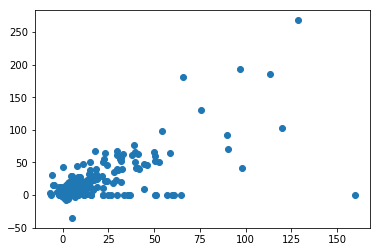

In [21]:
plt.scatter(result.predict(X_train), y_train)

## LightGBM

[1]	valid_0's l2: 0.251507
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.238041
[3]	valid_0's l2: 0.227136
[4]	valid_0's l2: 0.217965
[5]	valid_0's l2: 0.211112
[6]	valid_0's l2: 0.206962
[7]	valid_0's l2: 0.204949
[8]	valid_0's l2: 0.202558
[9]	valid_0's l2: 0.201155
[10]	valid_0's l2: 0.200405
[11]	valid_0's l2: 0.197515
[12]	valid_0's l2: 0.201498
[13]	valid_0's l2: 0.202485
[14]	valid_0's l2: 0.204682
[15]	valid_0's l2: 0.207585
[16]	valid_0's l2: 0.20987
[17]	valid_0's l2: 0.214026
[18]	valid_0's l2: 0.21772
[19]	valid_0's l2: 0.221565
[20]	valid_0's l2: 0.225678
Did not meet early stopping. Best iteration is:
[11]	valid_0's l2: 0.197515
R squared (in sample) is 0.105965
R squared (out sample) is 0.376146


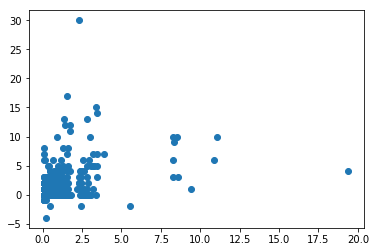

In [23]:
gbm = lgb.LGBMRegressor(num_leaves=50,
                        learning_rate=0.05,
                        n_estimators=20);
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=10);
pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
print("R squared (in sample) is %f" % Rsquare(pred_train, y_train))
pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print("R squared (out sample) is %f" % Rsquare(pred_test, y_test))
plt.scatter(pred_test, y_test)

## Augmented Dickey Fuller Test for Stationary Time Series

In [55]:
X, y = get_delta_deaths(36061)
adfTest = ts.adfuller(y, autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
#Add Critical Values
for key,value in adfTest[4].items():
    dfResults['Critical Value (%s)'%key] = value
print('Augmented Dickey-Fuller Test Results:')
print(dfResults)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -0.441649
P-Value                  0.902909
# Lags Used              2.000000
# Observations Used     44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
dtype: float64


/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Conclude: time series is stationary

In [41]:
fips_list = get_fips()
stationary = 0
non_stationary = 0
for fips in fips_list:
    X, y = get_delta_deaths_ratio(fips, clip_zeros=True)
    if len(y) < 6:
        continue
    adfTest = ts.adfuller(y, maxlag=4)
    if adfTest[1] > 0.05:
            non_stationary += 1
    else:
            stationary += 1

print ("stationary %d, non-stat %d" % (stationary, non_stationary))

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/home/sean/anaconda3/lib/python3.7/site-pac

stationary 817, non-stat 200


## ARIMA Model

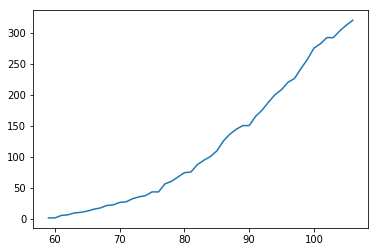

In [178]:
# some counties: King (53033), NYC (36061), Chicago (17031), LA (6037), Wayne, MI (26163), Queens(36059), King (nyc) (36047)
X, y = get_cum_deaths(53033)
plt.plot(X,y)

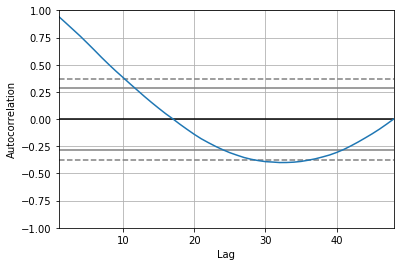

In [179]:
autocorrelation_plot(y)

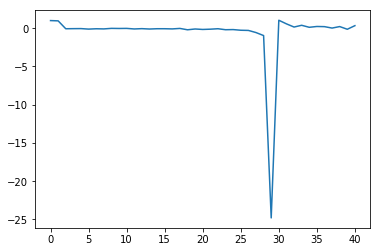

In [180]:
plt.plot(pacf(y))

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   46
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -125.876
Method:                       css-mle   S.D. of innovations              3.563
Date:                Fri, 17 Apr 2020   AIC                            267.753
Time:                        18:19:04   BIC                            282.382
Sample:                             2   HQIC                           273.233
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2213      0.049      4.557      0.000       0.126       0.316
ar.L1.D2.y     0.0198      0.158      0.125      0.901      -0.290       0.329
ar.L2.D2.y     0.3093      0.147      2.100      0.0

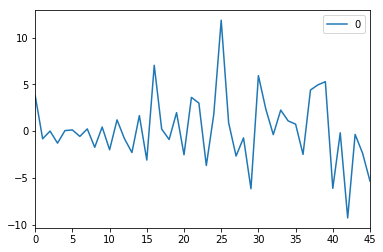

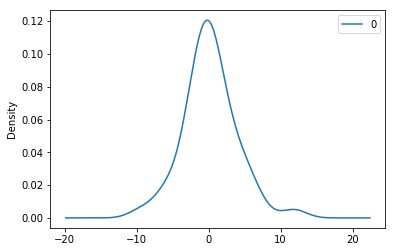

               0
count  46.000000
mean    0.189914
std     3.687064
min    -9.290565
25%    -1.935161
50%     0.021684
75%     1.919813
max    11.847360


In [181]:
model = ARIMA(y, order=(5,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

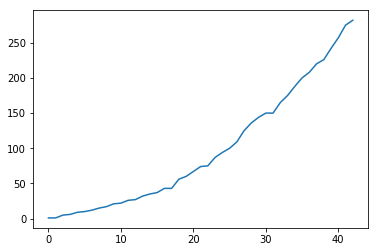

In [182]:
train_sz = int(len(y) * .75)
train_y, test_y = y[:-5], y[-5:]
plt.plot(train_y)

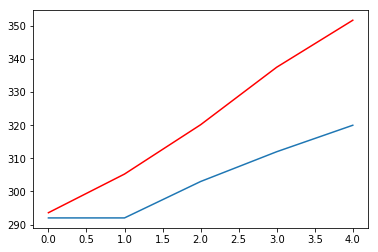

In [185]:
model= ARIMA(train_y, order=(5,2,1))
model_fit = model.fit(disp=0)
pred = model_fit.forecast(5)[0]
plt.plot(test_y)
plt.plot(pred, color='red')
plt.show()

# Doing Shit, But on States

In [6]:
class CumDeathCounterStates:
    def __init__(self):
        self.df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_states.csv")
        states = self.df.state.unique()

        self.cache = {}
        for state in states:
            self.cache[state] = self.get_cum_deaths(state)
    def get_cum_deaths(self, state_name):
        df_state = self.df[self.df.state == state_name]
        X = df_state.date.map(lambda day: (get_date(day) - get_date('2020-01-01')).days).values
        y_deaths = df_state.deaths.values
        return (X, y_deaths)
    def getY(self, state):
        return self.cache[state]
class CumCaseCounterStates:
    def __init__(self):
        self.df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_states.csv")
        states = self.df.state.unique()

        self.cache = {}
        for state in states:
            self.cache[state] = self.get_cum_cases(state)
    def get_cum_cases(self, state_name):
        df_state = self.df[self.df.state == state_name]
        X = df_state.date.map(lambda day: (get_date(day) - get_date('2020-01-01')).days).values
        y_cases = df_state.cases.values
        return (X, y_cases)
    def getY(self, state):
        return self.cache[state]
class DeltaCounterStates:
    def __init__(self, cumDeathCounterStates):
        self.cumDeathCounterStates = cumDeathCounterStates
    def getY(self, state):
        X, y = self.cumDeathCounterStates.getY(state)
        y_true = [y[0]]
        for i in range(1, len(y)):
            y_true.append(y[i] - y[i-1])
        return X, y_true
class RatioCounterStates:
    def __init__(self, counter):
        self.counter = counter
    def getY(self, state, avg_period=5):
        X_raw, y_raw = self.counter.getY(state)
        y = []
        running_sum = 0.0
        running_time = 0
        for i in range(len(X_raw)):
            if y_raw[i] == 0:
                y.append(0)
            elif running_sum == 0:
                y.append(1) # if this is the first case we define the signal as 1
            else:
                avg = running_sum/running_time
                y.append(y_raw[i]/avg)
            if running_time == avg_period:
                running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
            else:
                running_sum = running_sum + y_raw[i]
                running_time = running_time + 1    
            if running_sum == 0:
                running_time = 1
        return (X_raw, np.array(y))

In [24]:
cumDeathCounterStates = CumDeathCounterStates()
cumCaseCounterStates = CumCaseCounterStates()
deltaDeathCounterStates = DeltaCounterStates(cumDeathCounterStates)
deltaCaseCounterStates = DeltaCounterStates(cumCaseCounterStates)
ratioCounterStates = RatioCounterStates(deltaDeathCounterStates)

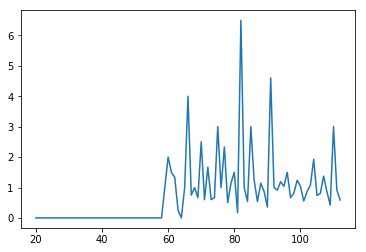

In [25]:
X, y = ratioCounterStates.getY("Washington",1)
plt.plot(X,y)

## Are State Daily Death Ratios Stationary (ADF, Again)